In [1]:
import sys
!{sys.executable} -m pip install mysql-connector
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mysql.connector
from datetime import datetime
mydb = mysql.connector.connect(
  host="iiwari-mariadb-server",
  user="root",
  passwd="d41k4Duu",
  database="iiwari_org"
)

In [2]:
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, timestamp, x,y,z,q FROM SensorData WHERE (node_id = 51719)  AND timestamp > '2019-09-24 13:05:08.078133+00:00' AND timestamp < '2019-09-30 13:05:08.078133+00:00'  AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND q < 100 AND z = 0 ");
df = pd.DataFrame(mycursor.fetchall())

In [3]:
x = np.zeros((3, 4, 5))
np.moveaxis(x, 0, -1).shape
#milestone["only_date"] = [df.date() for df in milestone["datetime"]]
table = pd.DataFrame(columns=list('NTXYZQ'))
table.N = df.node_id
table.T = df.timestamp
table.X = df.x
table.Y = df.y
table.Z = df.z
table.Q = df.q


table['T'] = table['T'].astype(str)
table['T'].dtype
table['T'] = table['T'].str.slice(2, -7)
print(table)

table['T'] = table['T'].astype('datetime64[ns]')
table['T'] = pd.Series(table['T']).dt.round("S")
table['T'] = table['T'].dt.date
table['T'].head()

            N                           T    X     Y  Z   Q
0       51719  2019-09-24 13:05:10.555608  153  2631  0  53
1       51719  2019-09-24 13:05:11.555657  170  2629  0  50
2       51719  2019-09-24 13:05:13.554065  107  2649  0  49
3       51719  2019-09-24 13:05:14.554038   51  2668  0  48
4       51719  2019-09-24 13:05:24.555276  108  2649  0  59
...       ...                         ...  ...   ... ..  ..
126968  51719   2019-09-30 11:22:56.68617  942  3622  0  34
126969  51719  2019-09-30 11:22:57.686567  950  3650  0  59
126970  51719  2019-09-30 11:22:58.686748  950  3650  0  45
126971  51719  2019-09-30 11:23:01.686116  950  3650  0  81
126972  51719  2019-09-30 11:23:03.686175  950  3650  0  33

[126973 rows x 6 columns]


0    2019-09-24
1    2019-09-24
2    2019-09-24
3    2019-09-24
4    2019-09-24
Name: T, dtype: object

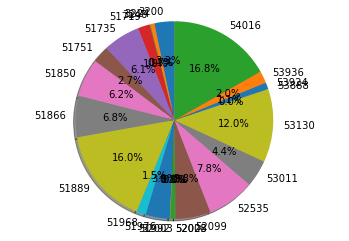

In [4]:
#biiragga ja balggi, barhaad gaverid
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, COUNT(node_id) FROM SensorData   WHERE timestamp > '2019-05-24 13:05:08.078133+00:00' AND timestamp < '2019-05-29 13:05:08.078133+00:00'  AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND   q <100 AND z = 0 GROUP BY node_id ");
nodes = pd.DataFrame(mycursor.fetchall())
nodes
nodes = nodes.rename(columns={'COUNT(node_id)': 'amount'})
labels = nodes.node_id
sizes = nodes.amount

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

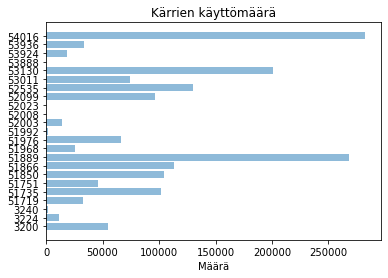

In [5]:
objects = nodes.node_id
y_pos = np.arange(len(objects))
performance = nodes.amount

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Määrä')
plt.title('Kärrien käyttömäärä')

plt.show()

In [ ]:
#Poistaa nopeuksien perusteella
prev = 0
val = 0
def calc_velocity(time_start, time_end):
    #diff_time = time_start - time_end
    diff_time = np.datetime64(time_start) - np.datetime64(time_end)
    diff_time.item().total_seconds()
    diff_time = diff_time / np.timedelta64(1, 's')
    if(diff_time > 0.1):
        return diff_time
    else:
        return 1
x = 0
for i in range(len(df.x)):
   # print(abs(df.iloc[i+1, 3] - abs(df.iloc[i, 3])))
    #print(abs(df.index[i+1]) - abs(df.index[i]))
    if(i < len(df.x)):
        #print(i , " " , x, " ", len(df.x))
        value1 = calc_velocity(df.iloc[i-x, 1], df.iloc[i-(1+x), 1])
        value2 = int((abs(df.iloc[i-x, 2])) - prev)
        val =  value2 / value1
        if (val > 60 or value2 > 100):
            df.drop([df.index[i-x]], axis = 0, inplace = True)
            prev = abs(df.iloc[i-x, 2])
            x +=1
        else:
            prev = abs(df.iloc[i-x, 2])
x = 0
for i in range(len(df.y)):
   # print(abs(df.iloc[i+1, 3] - abs(df.iloc[i, 3])))
    #print(abs(df.index[i+1]) - abs(df.index[i]))
    if(i < len(df.y)):
        value1 = calc_velocity(df.iloc[i-x, 1], df.iloc[i-(1+x), 1])
        value2 = int((abs(df.iloc[i-x, 3]))-prev)
        val = value2 / value1    
        if (val > 60 or value2 > 100):
            df.drop([df.index[i-x]], axis = 0)
            prev = abs(df.iloc[i-x , 3])
            x +=1
        else:
            prev = abs(df.iloc[i-x, 3])
    #print(prev)
    #if (abs(df.iloc[i+1, 3] - abs(df.iloc[i, 3]))) > 400:
        #print("We int")
        
print(len(df.x))
#devx = [df.iloc[i + 1, 2] - df.iloc[i, 2] for i in range(len(df.x)-1)]
devx = []
for i in range(len(df.x)):
    value1 = calc_velocity(df.iloc[i, 1], df.iloc[i-1, 1])
    val = int((abs(df.iloc[i, 2]) - prev)) / value1
    #print(val)
    devx.append(val)
    prev = abs(df.iloc[i, 2])

xmean = np.mean(devx, axis=0)
xsd = np.std(devx, axis=0)
print(xmean)
print(xsd)
i = 0
final_list = [x for x in df.x if (abs(x) > xmean - 0.5 * xsd)]
#final_list = [x for x in final_list if (x < xmean + 0. * xsd)]
for x in final_list:
    if(x < xmean + 6.75 * xsd):
        df.drop([df.index[i]], axis = 0, inplace = True)
        i -= 1
    i += 1
i = 0
#devy = [df.iloc[i + 1, 3] - df.iloc[i, 3] for i in range(len(df.y)-1)]
devy = []
for i in range(len(df.y)):
    value1 = calc_velocity(df.iloc[i, 1], df.iloc[i-1, 1])
    val = int((abs(df.iloc[i, 3]) - prev)) / value1
    #print(val)
    devy.append(val)
    prev = abs(df.iloc[i, 3])
ymean = np.mean(devy, axis=0)
ysd = np.std(devy, axis=0)
print(ymean)
print(ysd)
final_list1 = [y for y in df.y if (abs(y) > ymean - 0.5 * ysd)]
i = 0
print(len(df.y))
for y in final_list1:
    if(y < ymean + 6.75 * ysd):
        df.drop([df.index[i]], axis = 0, inplace = True)
        i -= 1
    i += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


In [ ]:
#kuva    
df = df.drop(df[(df.x < 1000.0) & (df.y > 2000.0)].index)
plt.rcParams['figure.figsize'] = 20, 10
img = plt.imread("pic.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-800, 10406, 5220, -150])
ax.plot(df.x, df.y , marker='o', linewidth=0.2, markersize=3, color='firebrick')

x = df.x.tolist()
y = df.y.tolist()

df = df.drop(df[(df.x < 1000.0) & (df.y > 2000.0)].index)
df = df.drop(df[(df.x > 9000.0)].index)

In [ ]:
#heatmap
from scipy.ndimage import gaussian_filter
import matplotlib.cm as cm
def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    return heatmap.T, extent

extent=[-800, 10400, 5220, -250]
img2 = img
fig, axs = plt.subplots(2, 2)

sigmas = [0, 16, 32, 64]
for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.invert_yaxis()
        ax.plot(x, y, 'o', linewidth=0.2, markersize=3)
    else:
        img2, extent = myplot(x, y, s)
        ax.imshow(np.flipud(img2), extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

In [ ]:
import seaborn as sns
ax = sns.kdeplot(x, bw=.15)

In [ ]:
from collections import Counter
def Dublicates(x):
    elements = dict()
    for elem in elements:
        if elem in elements:
            elements[elem] += 1
        else:
            elements[elem] = 1
 
    elements = { key:value for key, value in elements.items() if value > 1}
    return elements

elements = dict(Counter(x))

elements = { key:value for key, value in elements.items() if value > 1}
 
for key, value in elements.items():
    print('x: arvo', key,'esiintyy', value, 'kertaa')

for key, value in elements.items():
    if value > 70:
        value = 1
    print('x: arvo',key,'esiintyy', value, 'kertaa')
x = df.x.tolist()

In [ ]:
def calc_velocity1(time_start, time_end, ):
    #diff_time = time_start - time_end
    diff_time = np.datetime64(time_start) - np.datetime64(time_end)
    diff_time.item().total_seconds()
    diff_time = diff_time / np.timedelta64(1, 's')
    if(diff_time > 0.1):
        return diff_time
    else:
        return 1
x = 0
import math  
def calculateDistance(x1,y1,x2,y2):  
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
    return dist
devx1 = []
time = []
dist = []
speed = []
i = 1
for i in range(len(df.x)):
    time.append(calc_velocity1(df.iloc[i, 1], df.iloc[i-1, 1]))
    #val = int((abs(df.iloc[i, 2]) - prev)) / value1
    dist.append(calculateDistance(abs(df.iloc[i, 2]), abs(df.iloc[i, 3]),abs(df.iloc[i-1, 2]),  abs(df.iloc[i-1, 3])))
    #print(val)
speed = []
for i in range(len(dist)):
    speed.append((dist[i] / 161)/time[i])
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg
print(cal_average(speed))

In [ ]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
tripEnd =[] 
print(tripEnd)
started = False
bol = False
for i in range(len(df)):
    #print(data.loc[data.index[i], 'x'],data.loc[data.index[i],'y'])
    if((df.loc[df.index[i], 'x'] > -800.0) & (df.loc[df.index[i],'x'] < 700) & (df.loc[df.index[i],'y'] > 0.0) & (df.loc[df.index[i],'y'] < 2199) &  started):
        tripEnd.append(i)
        #print(started)
        started = False
        #print("end")
    elif(((df.loc[df.index[i], 'x'] > -800.0) & (df.loc[df.index[i],'x'] < 700) & (df.loc[df.index[i],'y'] > 2200) & (df.loc[df.index[i],'y'] < 3100)) & (not started)):
        #print(started)
        started = True
        #print("start")
        
        
        
j1 = 0
for j in tripEnd:
    ax.plot(df.loc[j1:j,'x'],df.loc[j1:j,'y'] , linewidth=1, color=(rnd.randint(0,255),rnd.randint(0,255),rnd.randint(0,255)) )
    j1 = j +1

ax.imshow(img, extent=[-800, 10400, 5400, -200])
plt.show()
print("HE")
print(tripEnd)
print(df.loc[df.index[1], 'x'])
fig, ax = plt.subplots()
prev = 0
ax.imshow(img, extent=[-800, 10400, 5400, -200])
#print(tripEnd)
for j in tripEnd:
    #print(j)
    ax.plot(df.loc[prev:j,'x'],df.loc[prev:j,'y'] , linewidth=0.6, color=np.random.rand(3,) )
    prev = j 

In [ ]:
resy = [df.iloc[i + 1, 3] - df.iloc[i, 3] for i in range(len(df.y)-1)] 
#resy = df.y['3']-df.y['2']
#resy = df.iloc[1,3] - df.iloc[0,3]
prevy = 0
for y in resy:
    #print(abs(y-prevy))
    #print(y)
    prevy = y
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg

print("The average is", cal_average(resy))

In [ ]:
import sys
!{sys.executable} -m pip install ipywidgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
# Interact with specification of arguments
@interact
def show_articles_more_than(column=['node_id', 'datetime', 'x', 'y'], 
                            x=(10, 100000, 10)):
    return df.loc[df[column] > x]
plt.show()

In [ ]:
def start_and_end_date():
    interact(start_date=widgets.DatePicker(value=np.datetime64('2018-01-01')), end_date=widgets.DatePicker(value=np.datetime64('2019-01-01')))

In [ ]:
def print_articles_published(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    stat_df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
    total_words = stat_df['word_count'].sum()
    total_read_time = stat_df['read_time'].sum()
    num_articles = len(stat_df)
    print(f'You published {num_articles} articles between {start_date.date()} and {end_date.date()}.')
    print(f'These articles totalled {total_words:,} words and {total_read_time/60:.2f} hours to read.')
    
_ = interact(print_articles_published,
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-09-24')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2019-09-30')))

In [ ]:
from datetime import date, timedelta
d = 0
dates = []

start_date = date(2019, 10, 1)
end_date = date(2019, 10, 31)
delta = timedelta(days=1)
while start_date <= end_date:
    ts = start_date.strftime("%Y/%m/%d")
    start_date += delta
    d += 1
    dates.append(ts)
for i in dates:
    tsT = table.loc[table['T'] == i, :]
x = tsT.X.tolist()
y = tsT.Y.tolist()